In [66]:
import pickle
import numpy as np
import sklearn.preprocessing
from sklearn_pandas import DataFrameMapper
import pandas as pd

In [67]:
# Read the bids, replace NaN values with a dash because NaN are string categories we don't know
bids = pd.read_csv('../PROJECT/bids.csv', header=0)
bids.fillna('-', inplace=True)

In [68]:
# Load train and test bidders lists (nothing really interesting in that list)
train = pd.read_csv('../PROJECT/train.csv', header=0, index_col=0)
test = pd.read_csv('../PROJECT/test.csv', header=0, index_col=0)

In [69]:
# Join those 2 datasets together (-1 outcome meaning unknown i.e. test)
test['outcome'] = -1.0
bidders = pd.concat((train, test))

In [70]:
def computeStatsCat(series, normalizeCount = 1.0):

    n = float(series.shape[0])
    counts = series.value_counts()

    nbUnique = counts.count() / normalizeCount
    hiFreq = counts[0] / n
    loFreq = counts[-1] / n
    argmax = counts.index[0]
    stdFreq = np.std(counts / n)

    return (nbUnique, loFreq, hiFreq, stdFreq, argmax)

In [71]:
# Compute stats of numerical series without caring about interval between values
def computeStatsNumNoIntervals(series):

    min = series.min()
    max = series.max()
    mean = np.mean(series)
    std = np.std(series)
    perc20 = np.percentile(series, 20)
    perc50 = np.percentile(series, 50)
    perc80 = np.percentile(series, 80)

    return (min, max, mean, std, perc20, perc50, perc80)

In [72]:
# Compute stats of a numerical series, taking intervals between values into account
def computeStatsNum(series, copy = True):

    if copy:
        series = series.copy()

    series.sort_values()
    intervals = series[1:].as_matrix() - series[:-1].as_matrix()
    if len(intervals) < 1:
        intervals = np.array([0])

    nb = series.shape[0]
    min = series.min()
    max = series.max()
    range = max - min
    intervalsMin = np.min(intervals)
    intervalsMax = np.max(intervals)
    intervalsMean = np.mean(intervals)
    intervalsStd = np.std(intervals)
    intervals25 = np.percentile(intervals, 25)
    intervals50 = np.percentile(intervals, 50)
    intervals75 = np.percentile(intervals, 75)
    return (nb, min, max, range,
            intervalsMin, intervalsMax, intervalsMean, intervalsStd,
            intervals25, intervals50, intervals75)


In [73]:
# Compute stats about a numerical column of table, with stats on sub-groups of this column (auctions in our case).
def computeStatsNumWithGroupBy(table, column, groupby):

    # get series and groups
    series = table[column]
    groups = table.groupby(groupby)

    # global stats
    (nb, min, max, range,
    intervalsMin, intervalsMax, intervalsMean, intervalsStd,
    intervals25, intervals50, intervals75) = computeStatsNum(series)

    # stats by group
    X = []
    for _, group in groups:
        (grpNb, _, _, grpRange, grpIntervalsMin, grpIntervalsMax, grpIntervalsMean, grpIntervalsStd, _, _, _) = computeStatsNum(group[column])
        X.append([grpNb, grpRange, grpIntervalsMin, grpIntervalsMax, grpIntervalsMean, grpIntervalsStd])
    X = np.array(X)

    grpNbMean = np.mean(X[:,0])
    grpNbStd = np.std(X[:,0])
    grpRangeMean = np.mean(X[:,1])
    grpRangeStd = np.std(X[:,1])
    grpIntervalsMinMin = np.min(X[:,2])
    grpIntervalsMinMean = np.mean(X[:,2])
    grpIntervalsMaxMax = np.max(X[:,3])
    grpIntervalsMaxMean = np.mean(X[:,3])
    grpIntervalsMean = np.mean(X[:,4])
    grpIntervalsMeanStd = np.std(X[:,4])
    grpIntervalsStd = np.mean(X[:,5])
    
    return (nb, min, max, range,
            intervalsMin, intervalsMax, intervalsMean, intervalsStd,
            intervals25, intervals50, intervals75,
            grpNbMean, grpNbStd, grpRangeMean, grpRangeStd,
            grpIntervalsMinMin, grpIntervalsMinMean, grpIntervalsMaxMax, grpIntervalsMaxMean,
            grpIntervalsMean, grpIntervalsMeanStd, grpIntervalsStd)

In [74]:
def computeOutcomeProbaByCat(data, cats):
    stats = {}
    for cat in cats:
        stats[cat] = pd.DataFrame(data.groupby(cat).aggregate(np.mean).outcome)
        stats[cat].rename(columns={'outcome': cat+'Num'}, inplace=True)
    return stats

#bidsWithOutcome = pd.merge(bids, bidders[['outcome']], how='left', left_on='bidder_id', right_index=True)
#stats = computeOutcomeProbaByCat(bidsWithOutcome[bidsWithOutcome.outcome >= 0], [u'auction', u'merchandise', u'device', u'country', u'url'])

# Add real columns to bids dataframe
#for cat in stats:
#    bids = pd.merge(bids, stats[cat], how='left', left_on=cat, right_index=True)

In [75]:
# Init vars
Xids = []
X = []

# Old init for stats about merchadises
# merchandises = bids.merchandise.value_counts()

# For each bidder
for bidder, group in bids.groupby('bidder_id'):

    # Compute the stats
    (nbUniqueIP, loFreqIP, hiFreqIP, stdFreqIP, IP) = computeStatsCat(group.ip)
    (nbUniqueDevice, loFreqDevice, hiFreqDevice, stdFreqDevice, device) = computeStatsCat(group.device)
    (nbUniqueMerch, loFreqMerch, hiFreqMerch, stdFreqMerch, merch) = computeStatsCat(group.merchandise)
    (nbUniqueCountry, loFreqCountry, hiFreqCountry, stdFreqCountry, country) = computeStatsCat(group.country)
    (nbUniqueUrl, loFreqUrl, hiFreqUrl, stdFreqUrl, url) = computeStatsCat(group.url)
    (nbUniqueAuction, loFreqAuction, hiFreqAuction, stdFreqAuction, auction) = computeStatsCat(group.auction)
    (auctionNb, auctionMin, auctionMax, auctionRange,
    auctionIntervalsMin, auctionIntervalsMax, auctionIntervalsMean, auctionIntervalsStd,
    auctionIntervals25, auctionIntervals50, auctionIntervals75,
    auctionGrpNbMean, auctionGrpNbStd, auctionGrpRangeMean, auctionGrpRangeStd,
    auctionGrpIntervalsMinMin, auctionGrpIntervalsMinMean, auctionGrpIntervalsMaxMax, auctionGrpIntervalsMaxMean,
    auctionGrpIntervalsMean, auctionGrpIntervalsMeanStd, auctionGrpIntervalsStd) = computeStatsNumWithGroupBy(group, 'time', 'auction')
    
     # Save the stats
    # Also I don't really remember which category features I kept or not in my final submission :$
    # I think it was IP + device + merch + contry, but for computation time let's comment some of these
    x = [nbUniqueIP, loFreqIP, hiFreqIP, stdFreqIP, #IP,
          nbUniqueDevice, loFreqDevice, hiFreqDevice, stdFreqDevice, #device,
          nbUniqueMerch, loFreqMerch, hiFreqMerch, stdFreqMerch, merch,
          nbUniqueCountry, loFreqCountry, hiFreqCountry, stdFreqCountry, country,
          nbUniqueUrl, loFreqUrl, hiFreqUrl, stdFreqUrl, #url,
          nbUniqueAuction, loFreqAuction, hiFreqAuction, stdFreqAuction, #auction
          auctionNb, auctionMin, auctionMax, auctionRange,
          auctionIntervalsMin, auctionIntervalsMax, auctionIntervalsMean, auctionIntervalsStd,
          auctionIntervals25, auctionIntervals50, auctionIntervals75,
          auctionGrpNbMean, auctionGrpNbStd, auctionGrpRangeMean, auctionGrpRangeStd,
          auctionGrpIntervalsMinMin, auctionGrpIntervalsMinMean, auctionGrpIntervalsMaxMax, auctionGrpIntervalsMaxMean,
          auctionGrpIntervalsMean, auctionGrpIntervalsMeanStd, auctionGrpIntervalsStd]
    
    ## Old stats per merchandise
    # for key in merchandisesCounts.index:
    #     merchandisesTmp[key] = merchandisesCounts[key]
    #     merchandisesTmp2[key] = float(merchandisesCounts[key]) / len(group)
    # merchandisesTmp = merchandises * 0
    # merchandisesTmp2 = (merchandises * 0).astype('float')
    # merchandisesCounts = group.merchandise.value_counts()
    # x += merchandisesTmp.tolist();
    # x += merchandisesTmp2.tolist();

    # Old stats replacing using real value substitution of categories
    # catCols = []
    # for cat in stats:
    #     (catMin, catMax, catMean, catStd, catPerc20, catPerc50, catPerc80) = computeStatsNumNoIntervals(group[cat+'Num'])
    #     x += [catMin, catMax, catMean, catStd, catPerc20, catPerc50, catPerc80]

    # Save the stats in the result arrays
    Xids.append(bidder)
    X.append(x)
    
    
# Features labels
Xcols = ['nbUniqueIP', 'loFreqIP', 'hiFreqIP', 'stdFreqIP', #'IP',
              'nbUniqueDevice', 'loFreqDevice', 'hiFreqDevice', 'stdFreqDevice', #'device',
              'nbUniqueMerch', 'loFreqMerch', 'hiFreqMerch', 'stdFreqMerch', 'merch',
              'nbUniqueCountry', 'loFreqCountry', 'hiFreqCountry', 'stdFreqCountry', 'country',
              'nbUniqueUrl', 'loFreqUrl', 'hiFreqUrl', 'stdFreqUrl', #'url',
              'nbUniqueAuction', 'loFreqAuction', 'hiFreqAuction', 'stdFreqAuction','auctionNb', 'auctionMin', 'auctionMax', 'auctionRange',
              'auctionIntervalsMin', 'auctionIntervalsMax', 'auctionIntervalsMean', 'auctionIntervalsStd',
              'auctionIntervals25', 'auctionIntervals50', 'auctionIntervals75',
              'auctionGrpNbMean', 'auctionGrpNbStd', 'auctionGrpRangeMean', 'auctionGrpRangeStd',
              'auctionGrpIntervalsMinMin', 'auctionGrpIntervalsMinMean', 'auctionGrpIntervalsMaxMax', 'auctionGrpIntervalsMaxMean',
              'auctionGrpIntervalsMean', 'auctionGrpIntervalsMeanStd', 'auctionGrpIntervalsStd']
# Old features labels when replacing using real value substitution of categories
# for cat in stats:
#     Xcols += [cat + 'NumMin', cat + 'NumMax', cat + 'NumMean', cat + 'NumStd', cat + 'NumPerc20', cat + 'NumPerc50', cat + 'NumPerc80']
# Xcols += map(lambda x: "merch" + x + "Abs", merchandisesTmp.keys().tolist())
# Xcols += map(lambda x: "merch" + x + "Prop", merchandisesTmp.keys().tolist())

# Create a pandas dataset, remove NaN from dataset and show it
dataset = pd.DataFrame(X,index=Xids, columns=Xcols)
dataset.fillna(0.0, inplace=True)
dataset


,nbUniqueIP,loFreqIP,hiFreqIP,stdFreqIP,nbUniqueDevice,loFreqDevice,hiFreqDevice,stdFreqDevice,nbUniqueMerch,loFreqMerch,...,auctionGrpNbStd,auctionGrpRangeMean,auctionGrpRangeStd,auctionGrpIntervalsMinMin,auctionGrpIntervalsMinMean,auctionGrpIntervalsMaxMax,auctionGrpIntervalsMaxMean,auctionGrpIntervalsMean,auctionGrpIntervalsMeanStd,auctionGrpIntervalsStd
001068c415025a009fee375a12cff4fcnht8y,1.0,1.000000,1.000000,0.000000e+00,1.0,1.000000,1.000000,0.000000,1.0,1.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
002d229ffb247009810828f648afc2ef593rb,1.0,1.000000,1.000000,0.000000e+00,2.0,0.500000,0.500000,0.000000,1.0,1.0,...,0.000000,1.052632e+08,0.000000e+00,105263158.0,1.052632e+08,1.052632e+08,1.052632e+08,1.052632e+08,0.000000e+00,0.000000e+00
0030a2dd87ad2733e0873062e4f83954mkj86,1.0,1.000000,1.000000,0.000000e+00,1.0,1.000000,1.000000,0.000000,1.0,1.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3.0,0.333333,0.333333,0.000000e+00,3.0,0.333333,0.333333,0.000000,1.0,1.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
00486a11dff552c4bd7696265724ff81yeo9v,10.0,0.050000,0.300000,7.071068e-02,8.0,0.050000,0.350000,0.106066,1.0,1.0,...,0.634324,1.518721e+12,2.301461e+12,0.0,1.090126e+12,5.571737e+12,1.401996e+12,1.246061e+12,1.775155e+12,1.559352e+11
0051aef3fdeacdadba664b9b3b07e04e4coc6,10.0,0.014706,0.352941,1.196159e-01,6.0,0.014706,0.573529,0.212205,1.0,1.0,...,15.806328,3.658421e+12,3.867043e+12,0.0,2.938495e+12,1.070468e+13,3.235968e+12,2.957614e+12,4.165561e+12,5.661764e+10
0053b78cde37c4384a20d2da9aa4272aym4pb,1951.0,0.000091,0.203675,5.402422e-03,518.0,0.000091,0.074778,0.005825,1.0,1.0,...,69.590688,1.783254e+13,2.853382e+13,0.0,1.068965e+12,7.041958e+13,1.387711e+13,2.712753e+12,8.310077e+12,2.983981e+12
0061edfc5b07ff3d70d693883a38d370oy4fs,53.0,0.007463,0.082090,1.731162e-02,45.0,0.007463,0.089552,0.019300,1.0,1.0,...,3.234167,4.446215e+12,4.464034e+12,0.0,1.230456e+12,1.125195e+13,2.864519e+12,1.846340e+12,2.574046e+12,6.243586e+11
00862324eb508ca5202b6d4e5f1a80fc3t3lp,1.0,1.000000,1.000000,0.000000e+00,1.0,1.000000,1.000000,0.000000,1.0,1.0,...,0.000000,3.052632e+09,0.000000e+00,526315790.0,5.263158e+08,1.210526e+09,1.210526e+09,7.631579e+08,0.000000e+00,2.696566e+08
009479273c288b1dd096dc3087653499lrx3c,1.0,1.000000,1.000000,0.000000e+00,1.0,1.000000,1.000000,0.000000,1.0,1.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [76]:
# First lets join the dataset with outcome because it might be a useful info in the future ;)
datasetFull = dataset.join(bidders[['outcome']])
types = datasetFull.dtypes

# Create a mapper that "standard scale" numbers and binarize categories
mapperArg = []
for col, colType in types.iteritems():
    if col == 'outcome':
        continue
    if colType.name == 'float64' or colType.name =='int64':
        mapperArg.append((col, sklearn.preprocessing.StandardScaler()))
    else:
        mapperArg.append((col, sklearn.preprocessing.LabelBinarizer()))
mapper = DataFrameMapper(mapperArg)

# Apply the mapper to create the cdataset
Xids = datasetFull.index.tolist()
X = mapper.fit_transform(datasetFull)
y = datasetFull[['outcome']].as_matrix()

# Last check!
print(bidders['outcome'].value_counts())

# Save in pickle file
pickle.dump([Xids, X, y], open('Xy.pkl', 'wb'))

C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

-1.0    4700
 0.0    1910
 1.0     103
Name: outcome, dtype: int64


C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

In [77]:
# Machine Learning
import sklearn
import sklearn.ensemble
import sklearn.svm
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [78]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 8, 5.5

In [79]:
# Utility functions

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [80]:
# Plot a confusion matrix
def plotConfMap(confMat, classes=[], relative=False):

    width = len(confMat)
    height = len(confMat[0])

    oldParams = rcParams['figure.figsize']
    rcParams['figure.figsize'] = width, height

    fig = plt.figure()
    plt.clf()
    plt.grid(False)
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    if not relative:
        res = ax.imshow(confMat, cmap='coolwarm', interpolation='nearest')
    else:
        res = ax.imshow(confMat, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=100)

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(np.round(confMat[x][y], 1)), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')

    fig.colorbar(res)

    if len(classes) > 0:
        plt.xticks(range(width), classes)
        plt.yticks(range(height), classes)

    rcParams['figure.figsize'] = oldParams

    return fig

In [81]:
# Plot CV scores of a 2D grid search
def plotGridResults2D(x, y, x_label, y_label, grid_scores):

    scores = [s[1] for s in grid_scores]
    scores = np.array(scores).reshape(len(x), len(y))

    plt.figure()
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.RdYlGn)
    plt.xlabel(y_label)
    plt.ylabel(x_label)
    plt.colorbar()
    plt.xticks(np.arange(len(y)), y, rotation=45)
    plt.yticks(np.arange(len(x)), x)
    plt.title('Validation accuracy')

In [82]:
# Plot CV scores of a 1D "grid" search (a very narrow "grid")
def plotGridResults1D(x, x_label, grid_scores):

    scores = np.array([s[1] for s in grid_scores])

    plt.figure()
    plt.plot(scores)
    plt.xlabel(x_label)
    plt.ylabel('Score')
    plt.xticks(np.arange(len(x)), x, rotation=45)
    plt.title('Validation accuracy')

In [83]:
# Load
X_ids, X, y = pickle.load(open('Xy.pkl', 'rb'))
y = y.reshape(y.shape[0])
X_ids = np.array(X_ids)

In [84]:
# Split learn and final with outcome indices
i_final = (y == -1)
i_learn = (y > -1)

X_ids_final = X_ids[i_final]
X_ids_learn = X_ids[i_learn]
X_final = X[i_final, :]
X_learn = X[i_learn, :]
y_learn = y[i_learn]

In [85]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X_learn, y_learn, test_size=.25)

C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


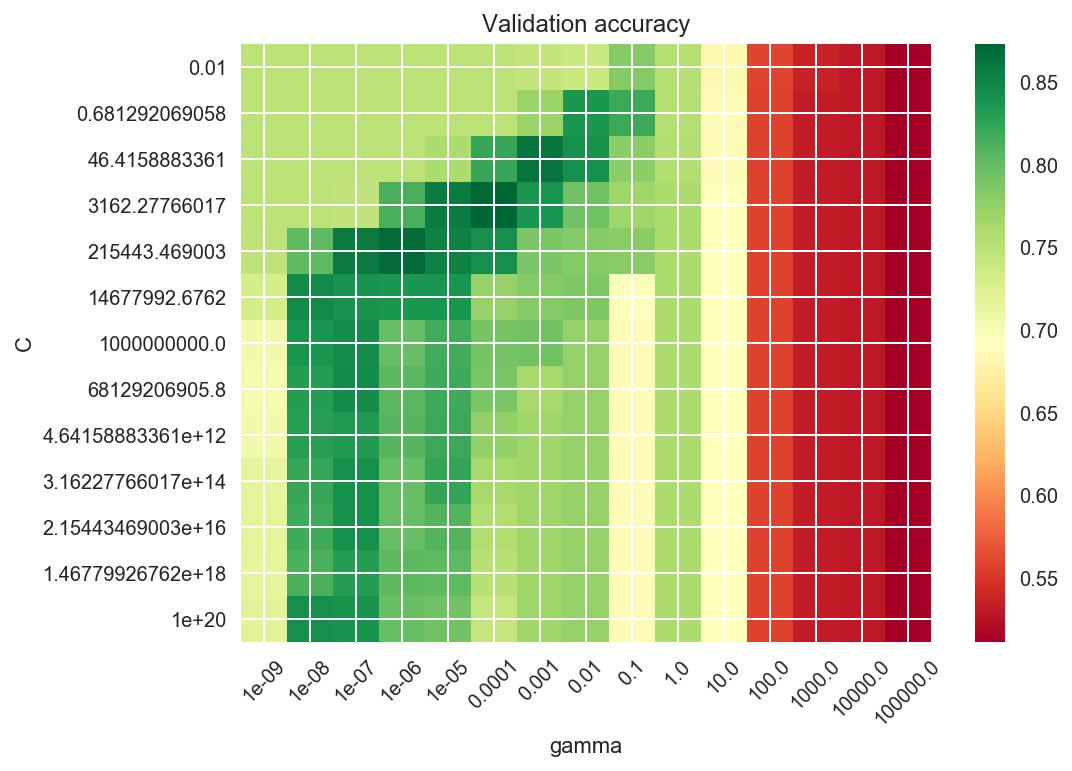

In [86]:
# Coarse grid
C_range = np.r_[np.logspace(-2, 20, 13)]
gamma_range = np.r_[np.logspace(-9, 5, 15)]
grid = GridSearchCV(sklearn.svm.SVC(C=1.0, kernel='rbf', class_weight='auto', verbose=False, max_iter=60000),
                    {'C' : C_range, 'gamma': gamma_range},
                   scoring='roc_auc', cv=10, n_jobs=8)
grid.fit(X_learn, y_learn)

plotGridResults2D(C_range, gamma_range, 'C', 'gamma', grid.grid_scores_)
plt.show()

In [87]:
# Display result
C_best = np.round(np.log10(grid.best_params_['C']))
gamma_best = np.round(np.log10(grid.best_params_['gamma']))
print('best C coarse:', C_best)
print('best gamma coarse:', gamma_best)

best C coarse: 4.0
best gamma coarse: -4.0


C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


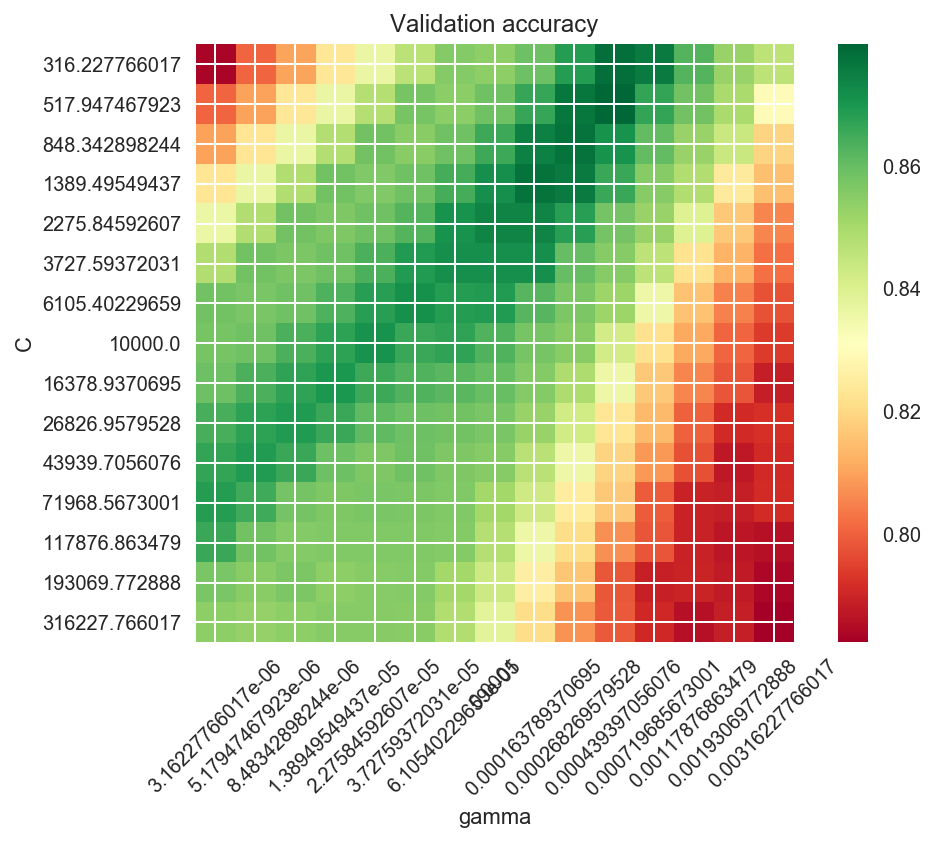

In [88]:
# Fine grid
C_range2 = np.r_[np.logspace(C_best - 1.5, C_best + 1.5, 15)]
gamma_range2 = np.r_[np.logspace(gamma_best - 1.5, gamma_best + 1.5, 15)]

gridFine = GridSearchCV(sklearn.svm.SVC(C=1.0, kernel='rbf', class_weight='auto', verbose=False, max_iter=60000),
                    {'C' : C_range2, 'gamma': gamma_range2},
                   scoring='roc_auc', cv=10, n_jobs=8)
gridFine.fit(X_learn, y_learn)

plotGridResults2D(C_range2, gamma_range2, 'C', 'gamma', gridFine.grid_scores_)

In [89]:
# Final result
bestClf = gridFine.best_estimator_
bestClf.probability = True
print(bestClf)

SVC(C=517.94746792312128, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.00043939705607607906,
  kernel='rbf', max_iter=60000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [90]:
# Fit it
bestClf.fit(X_train, y_train)
y_pred = bestClf.predict(X_test)

C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


In [91]:
# Classif report and conf mat
print(sklearn.metrics.classification_report(y_test, y_pred))
# print(plotConfMap(sklearn.metrics.confusion_matrix(y_test, y_pred)))
plt.show()

             precision    recall  f1-score   support

        0.0       0.99      0.83      0.90       473
        1.0       0.20      0.87      0.32        23

avg / total       0.96      0.83      0.87       496



In [92]:
# Predict scores
y_score = bestClf.decision_function(X_test)

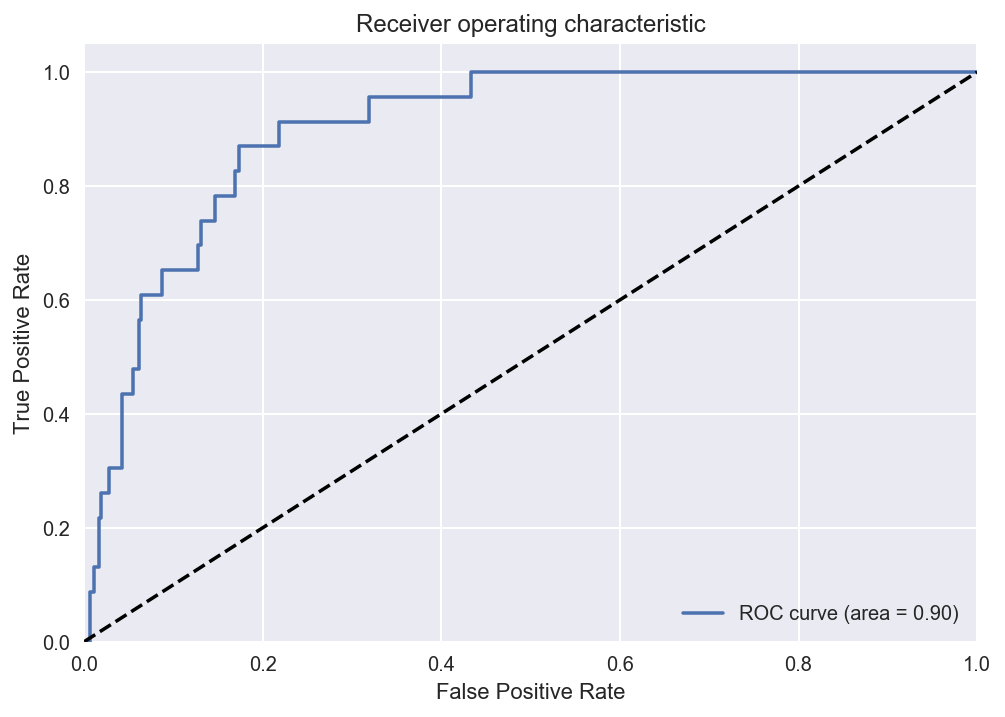

In [93]:
# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Fit on learn set and predict final set
bestClf.fit(X_learn, y_learn)
y_final = bestClf.predict_proba(X_final)[:,1]
y_final

# Dirty join with test.csv to order them like it was before...
# ... now that I look at this I am quite sure that Kaggle don't need them in the right
# order so all this is actually pretty stupid. Sorry :)
bidders_y_final = pd.DataFrame(np.c_[X_ids[i_final], y_final], columns=['bidder_id', 'prediction'])
bidders_y_final[['prediction']] = bidders_y_final[['prediction']].astype(float)
bidders_list = pd.read_csv('../PROJECT/test.csv', header=0)
bidders_list_final = pd.merge(bidders_list[['bidder_id']], bidders_y_final, how='left').fillna(0.0)

# Write results to file
# f = open('predictions_RBF_SVM.csv', 'wb')
# f.write(bidders_list_final.to_csv(index=False))
# f.close()

C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


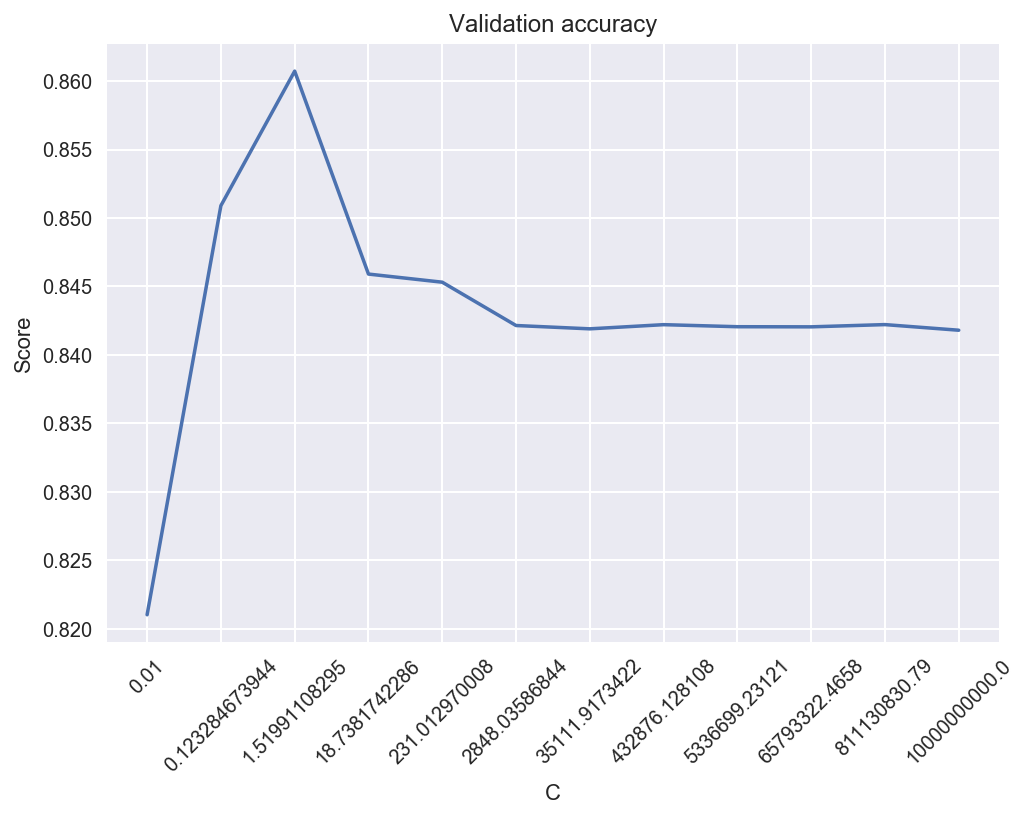

best C coarse: 0.0


C:\Users\vivid\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


LinearSVC(C=0.13894954943731375, class_weight='auto', dual=False,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=3000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=False)


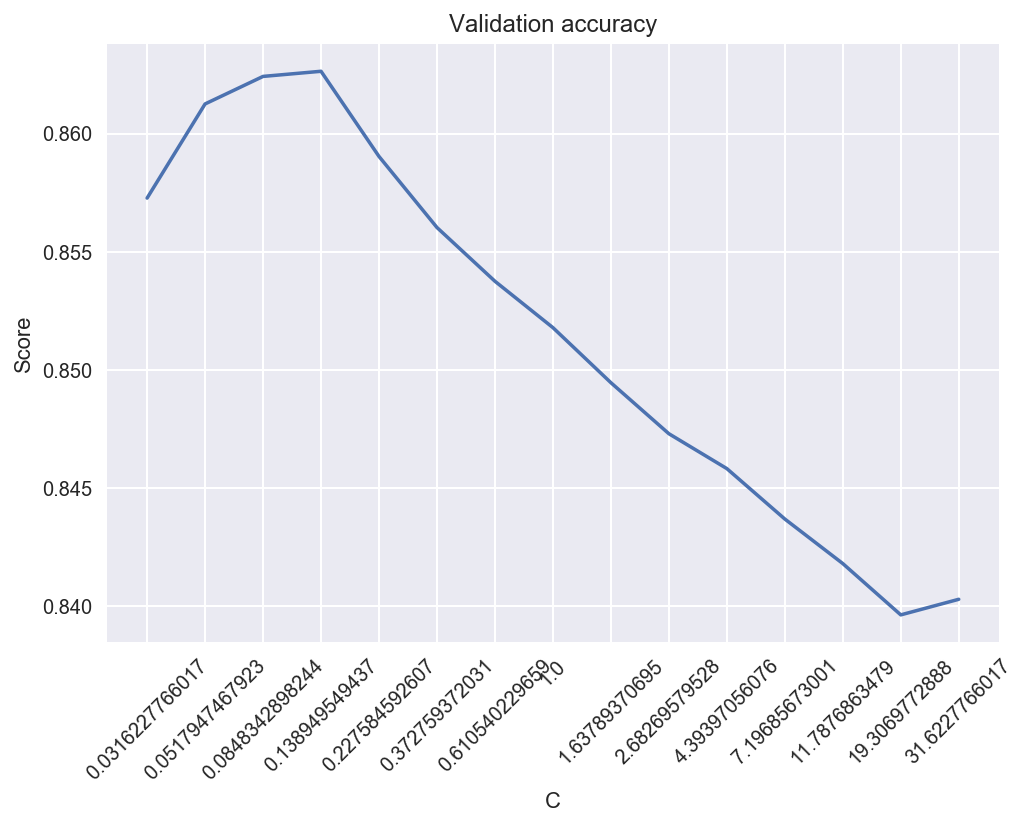

In [100]:
# Coarse grid
C_range = np.r_[np.logspace(-2, 10, 12)]
grid = GridSearchCV(sklearn.svm.LinearSVC(C=1.0, penalty='l1', class_weight='auto', dual=False, verbose=False, max_iter=3000),
                    {'C' : C_range},
                   cv=10, n_jobs=8, scoring='roc_auc')
grid.fit(X_learn, y_learn)

plotGridResults1D(C_range, 'C', grid.grid_scores_)
plt.show()
# Results
C_best = np.round(np.log10(grid.best_params_['C']))
print('best C coarse:', C_best)

# Fine grid
C_range2 = np.r_[np.logspace(C_best - 1.5, C_best + 1.5, 15)]

gridFine = GridSearchCV(sklearn.svm.LinearSVC(C=1.0, class_weight='auto', dual=False, verbose=False, max_iter=3000),
                    {'C' : C_range2},
                   cv=10, n_jobs=8, scoring='roc_auc')
gridFine.fit(X_learn, y_learn)

plotGridResults1D(C_range2, 'C', gridFine.grid_scores_)

# Final results
bestClf = gridFine.best_estimator_
bestClf.probability = True
print(bestClf)

In [ ]:
# Fit on train
bestClf.fit(X_train, y_train)
y_pred = bestClf.predict(X_test)

# Classification report
print(sklearn.metrics.classification_report(y_test, y_pred))
plotConfMap(sklearn.metrics.confusion_matrix(y_test, y_pred))
plt.show()

# Predict
y_score = bestClf.decision_function(X_test)

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [114]:
# Fit on learn
bestClf.fit(X_learn, y_learn)
y_final = bestClf.predict(X_final)

# Reorder prediction
bidders_y_final = pd.DataFrame(np.c_[X_ids[i_final], y_final], columns=['bidder_id', 'prediction'])
bidders_y_final[['prediction']] = bidders_y_final[['prediction']].astype(float)
bidders_list = pd.read_csv('../PROJECT/test.csv', header=0)
bidders_list_final = pd.merge(bidders_list[['bidder_id']], bidders_y_final, how='left').fillna(0.0)

# Save to file
f = open('predictions_Lin_SVM_L1.csv', 'w', encoding='utf-8-sig')
f.write(bidders_list_final.to_csv(index=False))
f.close()

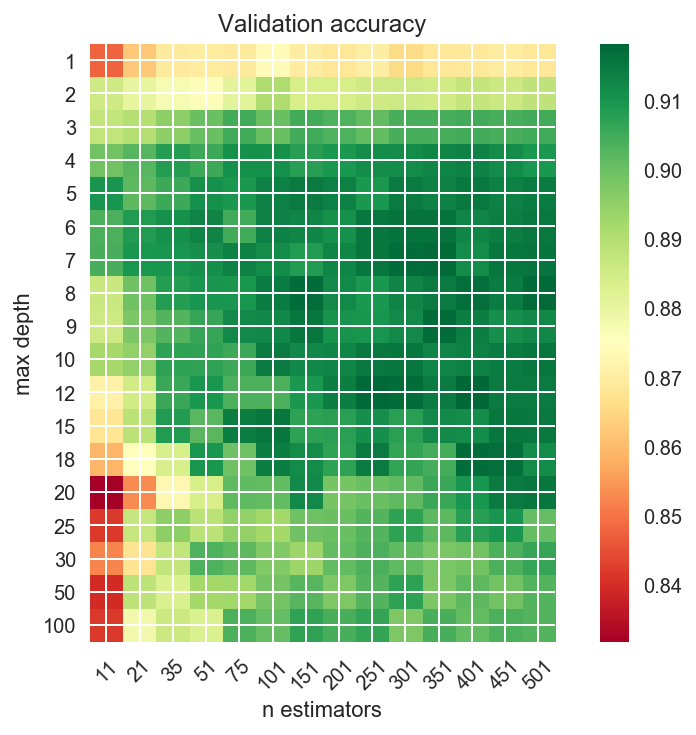

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=401, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [107]:
# Coarse grid
HP_range = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 25, 30, 50, 100])
HP2_range = np.array([11, 21, 35, 51, 75, 101, 151, 201, 251, 301, 351, 401, 451, 501])
grid = GridSearchCV(sklearn.ensemble.RandomForestClassifier(n_estimators=300, max_depth=None,
                                                                   max_features='auto', class_weight='auto'),
                    {'max_depth' : HP_range,
                    'n_estimators' : HP2_range},
                   cv=sklearn.cross_validation.StratifiedKFold(y_learn, 5), n_jobs=8, scoring='roc_auc')
grid.fit(X_learn, y_learn)

plotGridResults2D(HP_range, HP2_range, 'max depth', 'n estimators', grid.grid_scores_)
plt.show()

# Final res
bestClf = grid.best_estimator_
print(bestClf)

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98       473
        1.0       0.90      0.39      0.55        23

avg / total       0.97      0.97      0.96       496



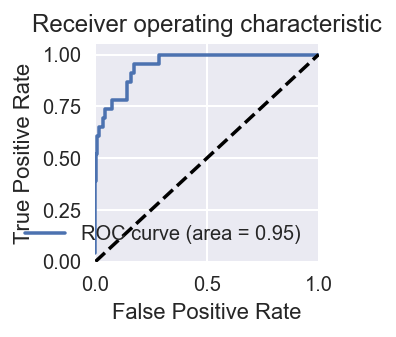

In [112]:
# Ok, I actally want to choose these paramters myself! I'm god here, I do what I want!
bestClf = sklearn.ensemble.RandomForestClassifier(max_depth=20, n_estimators=301,
                                        max_features='auto', class_weight='auto')

# Learn on train for test
bestClf.fit(X_train, y_train)
y_pred = bestClf.predict(X_test)

# Classification report
print(sklearn.metrics.classification_report(y_test, y_pred))
sklearn.metrics.confusion_matrix(y_test, y_pred)
plt.show()

# Predict scores
y_score = bestClf.predict_proba(X_test)[:,1]

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [115]:
bestClf.fit(X_learn, y_learn)
y_final = bestClf.predict_proba(X_final)[:,1]

bidders_y_final = pd.DataFrame(np.c_[X_ids[i_final], y_final], columns=['bidder_id', 'prediction'])
bidders_y_final[['prediction']] = bidders_y_final[['prediction']].astype(float)
bidders_list = pd.read_csv('../PROJECT/test.csv', header=0)
bidders_list_final = pd.merge(bidders_list[['bidder_id']], bidders_y_final, how='left').fillna(0.0)

f = open('predictions_RF_2.0.csv', 'w', encoding='utf-8-sig')
f.write(bidders_list_final.to_csv(index=False))
f.close()

Link:http://www.thomas-robert.fr/en/kaggles-human-or-robot-competition-feedback/